In [ ]:
# fetch_sets_from_smashgg.ipynbで取得した試合情報から、イロレーティングにより各選手のシード基準値を計算して出力する

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from collections import Counter

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option("display.max_colwidth", 80)

In [5]:
def elo_update_value(winner_rate, loser_rate):
    """
    勝者敗者のレートを順に与えると、イロレーティングに従いレート変化量を返す
    スマメイトの変化量と比べると、稀に1だけズレる模様。指数による誤差？(ex.1574と1618で前者が勝った場合、この関数では18が出力されるがメイトでは17変化する)
    https://smashmate.net/rate/342469/
    """
    return math.ceil(32/(10**((winner_rate-loser_rate)/400)+1)) # 変化0にはしないよう切り上げ処理

In [6]:
def sturges_rule(n):
    """
    スタージェスの公式
    """
    return round(1 + math.log2(n))

In [7]:
def update_rate_dict_and_df(initial_rate_dict, df):
    """
    入力: playerTagがキーの初期レート辞書、試合データフレーム
    処理: 全試合の結果にしたがってレートを更新する
    出力: 更新後のレート辞書、レート情報データフレーム

    篝火シードがplayerTag基準でしか取れないのでplayerTagをキーとする。playerTagが重複している選手は除去する
    """

    player_rate_dict = initial_rate_dict.copy()
    diffs = []
    updated_winner_rates = []
    updated_loser_rates = []

    for winner_playerTag, loser_playerTag in zip(df["winner_playerTag"], df["loser_playerTag"]):
        diff = elo_update_value(player_rate_dict[winner_playerTag], player_rate_dict[loser_playerTag])
        player_rate_dict[winner_playerTag] += diff
        player_rate_dict[loser_playerTag] -= diff
        diffs.append(diff)
        updated_winner_rates.append(player_rate_dict[winner_playerTag])
        updated_loser_rates.append(player_rate_dict[loser_playerTag])

    df_output = pd.DataFrame({"update_value":diffs, 
                              "updated_winner_rate":updated_winner_rates,
                              "updated_loser_rate":updated_loser_rates
                             })
    
    return player_rate_dict, df_output

In [8]:
def player_rate(search_id, df_update_values):
    """
    プレイヤーIDを与えると、そのプレイヤーのレート遷移データフレームを返す
    """
    df_output = (pd.concat([df, df_update_values], axis=1)
                 .pipe(lambda x: x[(x.winner_playerId == search_id)|(x.loser_playerId == search_id)])
                 .assign(searched_player_id = search_id)
                 .assign(searched_player_name = lambda x: x.searched_player_id.map(player_id_tag_dict))
                 .assign(searched_player_rate = lambda x: np.where(x.winner_playerId == search_id, x.updated_winner_rate, x.updated_loser_rate))
                 .assign(searched_player_finalPlacement = lambda x: np.where(x.winner_playerId == search_id, x.winner_finalPlacement, x.loser_finalPlacement))
                 .assign(update_value = lambda x: np.where(x.winner_playerId == search_id, x.update_value, -x.update_value))
                 [["searched_player_id", "searched_player_name", "tournament_startday", "tournament_event_id", "bracketId", "setRound_order", "id", "tournament_JPN_name", "setRound", "winnerName", "loserName", "searched_player_rate", "update_value", "updated_winner_rate", "updated_loser_rate", "searched_player_finalPlacement", "tournament_entrants"]]
                )
    return df_output

In [9]:
# fetch_sets_from_smashgg.ipynbで出力した試合情報を読み込む

df = pd.read_csv("df_sets.csv", encoding="utf-8-sig")
df

,id,entrant1Id,entrant2Id,entrant1Name,entrant2Name,entrant1Score,entrant2Score,completed,winnerId,loserId,winnerName,loserName,setRound,bracketId,tournament_event_id,winner_tag,winner_finalPlacement,winner_seed,winner_playerId,winner_progress_bar,winner_playerTag,loser_tag,loser_finalPlacement,loser_seed,loser_playerId,loser_progress_bar,loser_playerTag,tournament_url,tournament_name,event_name,tournament_id,tournament_JPN_name,tournament_country,tournament_state,tournament_city,tournament_entrants,tournament_startday,tournament_endday,setRound_order
0,36244343.0,7055308.0,7044186.0,Lir,ぐんそう,2.0,0.0,True,7055308.0,7044186.0,Lir,ぐんそう,Winners Round 1,1460283.0,558662,Lir,65,54,1486058,False,Lir,ぐんそう,97,129,570710,False,ぐんそう,https://smash.gg/tournament/3-kagaribi-3/event/singles/overview,3-kagaribi-3,singles,275805,篝火#3 / Kagaribi#3,JP,東京都,大田区,132,2021-03-27,2021-03-27,11.0
1,36244415.0,7055248.0,7044186.0,Rom,ぐんそう,0.0,2.0,True,7044186.0,7055248.0,ぐんそう,Rom,Losers Round 1,1460283.0,558662,ぐんそう,97,129,570710,False,ぐんそう,Rom,129,81,29912,False,Rom,https://smash.gg/tournament/3-kagaribi-3/event/singles/overview,3-kagaribi-3,singles,275805,篝火#3 / Kagaribi#3,JP,東京都,大田区,132,2021-03-27,2021-03-27,12.0
2,36244358.0,7007280.0,7055308.0,GW | zackray,Lir,2.0,0.0,True,7007280.0,7055308.0,GW | zackray,Lir,Winners Round 2,1460283.0,558662,GW | zackray,4,1,498962,False,zackray,Lir,65,54,1486058,False,Lir,https://smash.gg/tournament/3-kagaribi-3/event/singles/overview,3-kagaribi-3,singles,275805,篝火#3 / Kagaribi#3,JP,東京都,大田区,132,2021-03-27,2021-03-27,13.0
3,36244359.0,7055285.0,7055283.0,けさん,のーまる,0.0,2.0,True,7055283.0,7055285.0,のーまる,けさん,Winners Round 2,1460283.0,558662,のーまる,65,72,2215177,False,のーまる,けさん,97,64,1398291,False,ちょけ,https://smash.gg/tournament/3-kagaribi-3/event/singles/overview,3-kagaribi-3,singles,275805,篝火#3 / Kagaribi#3,JP,東京都,大田区,132,2021-03-27,2021-03-27,13.0
4,36244360.0,7010227.0,7055273.0,Yoshimoto | Rain,Dackie,2.0,0.0,True,7010227.0,7055273.0,Yoshimoto | Rain,Dackie,Winners Round 2,1460283.0,558662,Yoshimoto | Rain,49,1,135808,False,Rain,Dackie,65,43,1471808,False,Dackie,https://smash.gg/tournament/3-kagaribi-3/event/singles/overview,3-kagaribi-3,singles,275805,篝火#3 / Kagaribi#3,JP,東京都,大田区,132,2021-03-27,2021-03-27,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34031,55221097.0,11897223.0,11898399.0,いなばっち,Danger Cat,2.0,0.0,True,11897223.0,11898399.0,いなばっち,Danger Cat,Winners Semi-Final,1925126.0,820764,いなばっち,1,2,2528015,False,いなばっち,Danger Cat,2,11,40454,False,Danger Cat,https://www.start.gg/tournament/61-sp/event/sp,61-sp,sp,499859,第61回 美らブラSP 沖縄スマブラ大会 うるま市,JP,沖縄県,うるま市,19,2022-12-18,2022-12-18,36.0
34032,55221129.0,11863945.0,11898399.0,れお,Danger Cat,0.0,2.0,True,11898399.0,11863945.0,Danger Cat,れお,Losers Semi-Final,1925126.0,820764,Danger Cat,2,11,40454,False,Danger Cat,れお,4,3,2770949,False,れお,https://www.start.gg/tournament/61-sp/event/sp,61-sp,sp,499859,第61回 美らブラSP 沖縄スマブラ大会 うるま市,JP,沖縄県,うるま市,19,2022-12-18,2022-12-18,37.0
34033,55221098.0,11863973.0,11897223.0,FTJ,いなばっち,0.0,2.0,True,11897223.0,11863973.0,いなばっち,FTJ,Winners Final,1925126.0,820764,いなばっち,1,2,2528015,False,いなばっち,FTJ,3,1,2712138,False,FTJ,https://www.start.gg/tournament/61-sp/event/sp,61-sp,sp,499859,第61回 美らブラSP 沖縄スマブラ大会 うるま市,JP,沖縄県,うるま市,19,2022-12-18,2022-12-18,39.0
34034,55221130.0,11863973.0,11898399.0,FTJ,Danger Cat,0.0,2.0,True,11898399.0,11863973.0,Danger Cat,FTJ,Losers Final,1925126.0,820764,Danger Cat,2,11,40454,False,Danger Cat,FTJ,3,1,2712138,False,FTJ,https://www.start.gg/tournament/61-sp/event/sp,61-sp,sp,499859,第61回 美らブラSP 沖縄スマブラ大会 うるま市,JP,沖縄県,うるま市,19,2022-12-18,2022-12-18,40.0


([<matplotlib.axis.XTick at 0x2bdab9bc310>,
 <a list of 11 Text major ticklabel objects>)

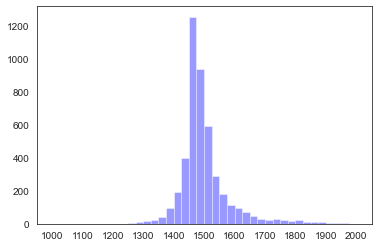

In [12]:
# 全員レート1500スタートのナイーブ手法
# 分布はいい感じだが、序盤の大会の運要素があまりに大きく、全員同レートの仮定に無理がある

naive_rate_dict, df_naive_update_values = update_rate_dict_and_df(defaultdict(lambda:1500), df)
sns.set_style(style="white")
sns.distplot(list(naive_rate_dict.values()), kde=False, color='blue', bins=list(range(1000,2025,25)))
plt.xticks(list(range(1000,2100,100)))

([<matplotlib.axis.XTick at 0x2bdabd25700>,
 <a list of 12 Text major ticklabel objects>)

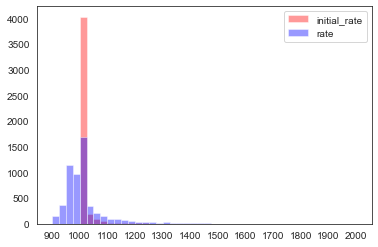

In [13]:
# 初期値用の篝火シードポイントを辞書形式で読み込み、最小値1000最大値2000に正規化し、レート遷移を求める
# 初期値が1000付近に偏りすぎていて全員1500と大して変わらない。中央値がズレるだけ

df_initial_seed = pd.read_excel("kagaribi_8_seed_point.xlsx").pipe(lambda x: x[x.dup == 1])

y1, y2 = 1000, 2000
x1, x2 = df_initial_seed.kagaribi_8_seed_point.min(), df_initial_seed.kagaribi_8_seed_point.max()
a = (y2-y1)/(x2-x1)

df_initial_seed["kagaribi_8_seed_point"] = df_initial_seed.kagaribi_8_seed_point.apply(lambda x:round(a*x + (y1-a*x1)))

initial_rate_dict = defaultdict(lambda:df_initial_seed.kagaribi_8_seed_point.median(), dict(zip(df_initial_seed.playerTag, df_initial_seed.kagaribi_8_seed_point)))

# 正規化した値を初期値としてレート計算
kagaribi_rate_dict, df_kagaribi_update_values = update_rate_dict_and_df(initial_rate_dict, df)

# 初期値と最終レートをプロット
sns.distplot(list(initial_rate_dict.values()), kde=False, bins=list(range(900,2025,25)), color='red', label="initial_rate")
sns.distplot(list(kagaribi_rate_dict.values()), kde=False, bins=list(range(900,2025,25)), color='blue', label="rate")
plt.legend()
plt.xticks(list(range(900,2100,100)))
plt.show()

13

12

([<matplotlib.axis.XTick at 0x2bdae8b1640>,
 <a list of 12 Text major ticklabel objects>)

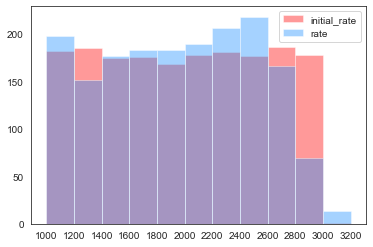

In [14]:
# 篝火シード順に順位をつけ、1,2,3位にそれぞれレート3000,2999,2998,...を割り当てていき初期値とする(同率には同じレートを割り当てる)
# 初期値未設定のプレイヤーは下位20%点からスタート
# ポイント300位が1位に勝った場合と1300位が1000位に勝った場合のレート変動がほぼ同じになってしまう

df_initial_seed = (pd.read_excel("kagaribi_8_seed_point.xlsx")
                   .pipe(lambda x: x[x.dup == 1])
                   .assign(initial_rate = lambda x:3001 - x.kagaribi_rank)
                  )
initial_rate_dict = defaultdict(lambda:df_initial_seed.initial_rate.quantile(0.2), dict(zip(df_initial_seed.playerTag, df_initial_seed.initial_rate)))
kagaribi_rate_dict, df_kagaribi_update_values = update_rate_dict_and_df(initial_rate_dict, df)

# スタージェスの公式でヒストグラムの階級数の目安を確認
sturges_rule(len(initial_rate_dict))
bins=list(range(1000,3400,200))
len(bins)

# 初期値と最終レートをプロット
sns.distplot(list(initial_rate_dict.values()), kde=False, bins=bins, color='red', label="initial_rate")
sns.distplot(list(kagaribi_rate_dict.values()), kde=False, bins=bins, color='dodgerblue', label="rate")
plt.legend()
plt.xticks(bins)
plt.savefig('rate_hist.png')
plt.show()

13

9

([<matplotlib.axis.XTick at 0x2bdae9ae910>,
 <a list of 9 Text major ticklabel objects>)

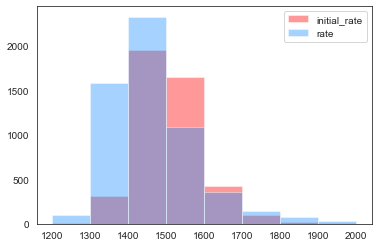

In [15]:
# スマメイト第16期と同じレート分布にする。人数を合わせてマージ
# 同シードポイントなのに異なる初期値の箇所が出ないよう、同シードポイントの最高初期値に合わせる

df_initial_seed = (pd.read_excel("kagaribi_8_seed_point.xlsx")
                   .pipe(lambda x: x[x.dup == 1])
                  )

# メイト分布に合わせてレート2400, 2300, ...の人数を割り当てる。端数は切り上げて後で調整する
df_smamate_16 = (pd.read_excel("smamate_16_rate.xlsx")
                 .assign(new_n = lambda x: (x.ratio*len(df_initial_seed)).apply(lambda y: math.ceil(y)))
                )

initial_rate_list = []
for i in range(len(df_smamate_16)):
    initial_rate_list.extend([(df_smamate_16.rate_range[i] + 1500)//2] * df_smamate_16.new_n[i])

df_initial_seed["initial_rate"] = initial_rate_list[:len(df_initial_seed)] # 端数切り上げにより超過する分をカット
    

initial_rate_dict = defaultdict(lambda:df_initial_seed.initial_rate.quantile(0.2), dict(zip(df_initial_seed.playerTag, df_initial_seed.initial_rate)))
kagaribi_rate_dict, df_kagaribi_update_values = update_rate_dict_and_df(initial_rate_dict, df)

# スタージェスの公式でヒストグラムの階級数の目安を確認
sturges_rule(len(initial_rate_dict))
bins=list(range(1200,2100,100))
len(bins)

# 初期値と最終レートをプロット
sns.distplot(list(initial_rate_dict.values()), kde=False, bins=bins, color='red', label="initial_rate")
sns.distplot(list(kagaribi_rate_dict.values()), kde=False, bins=bins, color='dodgerblue', label="rate")
plt.legend()
plt.xticks(bins)
plt.savefig('rate_hist.png')
plt.show()

count    4471.000000
mean     1483.135764
std        86.367713
min      1250.000000
25%      1450.000000
50%      1450.000000
75%      1550.000000
max      1950.000000
dtype: float64

([<matplotlib.axis.XTick at 0x2bdae51f310>,
 <a list of 9 Text major ticklabel objects>)

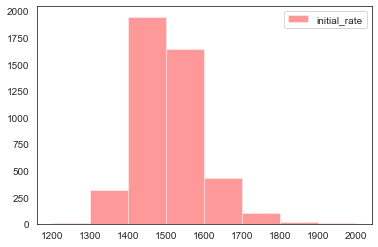

In [16]:
# 初期レートだけプロット

pd.Series(list(initial_rate_dict.values())).describe()

sns.distplot(list(initial_rate_dict.values()), kde=False, bins=bins, color='red', label="initial_rate")
plt.legend()
plt.xticks(bins)
plt.savefig('initial_rate_hist.png')
plt.show()

In [10]:
# プレイヤーマスタを読み込み、IDとtagの辞書を作る

df_players = (pd.read_csv("df_players.csv", encoding="utf-8-sig")
              [["playerId", "playerTag"]] # 大会&プレイヤー別に記録されているので、プレイヤー別に直す
              .drop_duplicates()
             )
player_id_tag_dict = dict(zip(df_players.playerId, df_players.playerTag))

In [17]:
# プレイヤーごとのレート収支をまとめたデータフレームを作る
# playerIdより少ない人数分出力される(棄権等で試合が無いプレイヤーが落ちている？)

df_player_rate = pd.DataFrame()

for player_id in tqdm(set(df_players.playerId.to_list())):
    df_player_rate = pd.concat([df_player_rate, player_rate(player_id, df_kagaribi_update_values)])

df_player_rate = (df_player_rate
                  .sort_values(["searched_player_id", "update_value"], ascending=False)
                  .assign(match_cumcount = lambda x: x.groupby('searched_player_id').cumcount()+1) # 1スタートとする
                 )

df_player_rate.to_csv("df_player_rate.csv", index=False, encoding="utf-8-sig")
df_player_rate

100%|██████████| 5115/5115 [02:46<00:00, 30.75it/s]


,searched_player_id,searched_player_name,tournament_startday,tournament_event_id,bracketId,setRound_order,id,tournament_JPN_name,setRound,winnerName,loserName,searched_player_rate,update_value,updated_winner_rate,updated_loser_rate,searched_player_finalPlacement,tournament_entrants,match_cumcount
34017,3174946,シラス,2022-12-18,820764,1925126.0,12.0,55221119.0,第61回 美らブラSP 沖縄スマブラ大会 うるま市,Losers Round 1,シラス,Crackle,1577.0,9,1577.0,1375.0,9,19,1
34012,3174946,シラス,2022-12-18,820764,1925126.0,11.0,55221088.0,第61回 美らブラSP 沖縄スマブラ大会 うるま市,Winners Round 1,いなばっち,シラス,1568.0,-18,1579.0,1568.0,9,19,2
34020,3174946,シラス,2022-12-18,820764,1925126.0,14.0,55221123.0,第61回 美らブラSP 沖縄スマブラ大会 うるま市,Losers Round 2,ワルク,シラス,1554.0,-23,1445.0,1554.0,9,19,3
33846,3171046,カｬス,2022-12-17,826121,1934554.0,4.0,55157109.0,北陸トライスマッシュ4,Round 4,カｬス,マルガリータ,1390.0,18,1390.0,1388.0,49,96,1
33729,3171046,カｬス,2022-12-17,826121,1934531.0,13.0,55158406.0,北陸トライスマッシュ4,Winners Round 2,カｬス,まさやん,1416.0,16,1416.0,1371.0,49,96,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14376,23241,Abadango,2022-05-28,722250,1751429.0,36.0,47782905.0,第29回クロブラ/神奈川スマブラ対戦会クロブラ,Winners Semi-Final,zuya,SNB | Abadango,1822.0,-25,1659.0,1822.0,17,102,145
18537,23241,Abadango,2022-06-27,739547,1783613.0,13.0,48937940.0,WINNER! #12,Winners Round 2,まちゃまっちゃ,SNB | Abadango,1807.0,-25,1654.0,1807.0,17,41,146
32255,23241,Abadango,2022-12-03,802437,1893981.0,14.0,54735727.0,西武撃/seibugeki #12,Losers Round 2,テト,SNB | Abadango,1884.0,-25,1742.0,1884.0,33,435,147
76,23241,Abadango,2021-03-27,558662,1460285.0,36.0,36244586.0,篝火#3 / Kagaribi#3,Winners Semi-Final,yuzu,SNB | Abadango,1781.0,-29,1474.0,1781.0,17,132,148


In [49]:
# # チェック用

# (df_player_rate[df_player_rate.searched_player_name == "おがとう"]
# #  .sort_values(["tournament_startday", "tournament_event_id", "bracketId", "setRound_order", "id"])
#  .assign(searched_player_rate = lambda x: x.searched_player_rate.astype(int))
#  [["tournament_startday", "tournament_JPN_name", "tournament_entrants", "setRound", 'winnerName', 'loserName', 'searched_player_rate', 'update_value']]
# ).head(10)

In [50]:
# # チェック用

# (df_player_rate[df_player_rate.searched_player_name == "あcola"]
#  .sort_values(["tournament_startday", "tournament_event_id", "bracketId", "setRound_order", "id"])
#  .assign(searched_player_rate = lambda x: x.searched_player_rate.astype(int))
#  [['winnerName', 'loserName', 'searched_player_rate', 'update_value']]
#  .sort_values("update_value", ascending=False)
#  .head(15)
#  .drop(columns="searched_player_rate")
# )

In [19]:
# 試合数分布を調べる

df_tmp = (df_player_rate
          .pipe(lambda x: x[x.update_value > 0])
          .groupby("searched_player_id", as_index=False).count()
          [["searched_player_id", "id"]]
          .rename(columns={"id":"n_plus_match_per_player"})
         )

df_rate_balance = (df_player_rate
                   .groupby(["searched_player_id", "searched_player_name"], as_index=False).count()
                   [["searched_player_id", "searched_player_name", "id"]]
                   .rename(columns={"id":"n_match"})
                   .merge(df_tmp, on="searched_player_id", how="left")
                   .fillna(0)
                   .rename(columns={"searched_player_name":"playerTag"})
                    )
df_rate_balance

,searched_player_id,playerTag,n_match,n_plus_match_per_player
0,23241,Abadango,149,99.0
1,26474,TOOMUCHDOG,4,1.0
2,29847,Nasubi,26,11.0
3,29873,Kei,25,10.0
4,29912,Rom,3,0.0
...,...,...,...,...
4804,3165491,yanbarukuina,2,0.0
4805,3165648,銀二ノ介,3,0.0
4806,3165944,まいく,3,0.0
4807,3171046,カｬス,7,2.0


count    4809.000000
mean       14.155126
std        23.952664
min         1.000000
25%         3.000000
50%         6.000000
75%        13.000000
max       281.000000
Name: n_match, dtype: float64

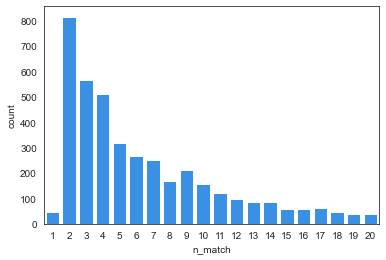

In [20]:
# 条件なしの場合、試合数の中央値は6試合と分かる

df_rate_balance.n_match.describe()
sns.countplot(x="n_match", data=df_rate_balance[df_rate_balance.n_match<=20], color='dodgerblue')
plt.savefig('n_match_hist.png')

count    4809.000000
mean        7.077563
std        15.740790
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
max       219.000000
Name: n_plus_match_per_player, dtype: float64

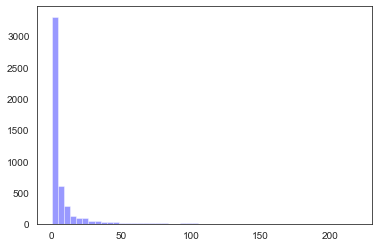

In [21]:
# レート収支黒字試合のみの場合、試合数の中央値は2試合と分かる

df_rate_balance.n_plus_match_per_player.describe()
sns.distplot(df_rate_balance.n_plus_match_per_player.to_list(), kde=False, color='blue')

In [35]:
# レート収支降順ソートした後に所定の試合数だけ各プレイヤーから抽出し、レート更新値を計算し直す
# searched_player_nameで集計すると同名プレイヤーが合成されてしまうので注意

n_pickup_match = 10

df_update = (df_player_rate
             .pipe(lambda x: x[x.match_cumcount <= n_pickup_match])
             .groupby(["searched_player_id", "searched_player_name"], as_index=False).sum()
             [["searched_player_id", "searched_player_name", "update_value"]]
             .rename(columns={"searched_player_id":"playerId", "searched_player_name":"playerTag"})
             .sort_values("update_value", ascending=False)
             .assign(playerTag_count = lambda x:x.groupby("playerTag")["playerTag"].transform("count")) # playerTag重複数
            )
df_update

,playerId,playerTag,update_value,playerTag_count
2123,2485238,かえる,267,2
1017,1497801,Neo,264,1
109,498179,Nao,254,1
895,1478572,ヒデヨシ,252,2
1779,2237419,かじん,252,1
...,...,...,...,...
3199,2757310,やけくそブッパマン,-126,1
4196,2954955,ウッチャン,-130,1
3270,2776879,こた,-131,1
1720,2227847,もっさん,-131,2


In [73]:
(df_update
    .pipe(lambda x: x[x.playerTag_count == 1]) # playerTag重複プレイヤーには意味のない数値をマージしていくので一旦絞る
    .assign(initial_rate = lambda x: x.playerTag.map(initial_rate_dict)) # 初期レート追加
    .merge(df_rate_balance[["playerTag", "n_match"]].drop_duplicates("playerTag"), on="playerTag", how="left") # 試合数追加
    .assign(n_match = lambda x: x.n_match.astype(int))
    .assign(update_value = lambda x: x.update_value.astype(int))
    .assign(rate = lambda x: (x.initial_rate + x.update_value).astype(int))
    .sort_values("rate", ascending=False)
    .merge(pd.read_excel("kagaribi_8_seed_point.xlsx")
          .pipe(lambda x: x[x.dup == 1]) # playerTagが重複しているプレイヤーは除いて篝火シードと順位をマージ
          [["playerTag", "kagaribi_8_seed_point", "kagaribi_rank"]]
          ,on="playerTag", how="left")
    .fillna(-1) # 篝火シードと順位をマージできなかった箇所にintのダミー値を挿入。最初から"-"を挿入すると後のnp.whereでエラー
    .assign(new_rank = lambda x: x.rate.rank(ascending=False, method='min').astype(int))
    .assign(rank_diff = lambda x: np.where(x.kagaribi_rank == -1, "-", (x.kagaribi_rank - x.new_rank).astype(int)))
    .assign(kagaribi_8_seed_point = lambda x: np.where(x.kagaribi_rank == -1, "-", x.kagaribi_8_seed_point))
    .assign(kagaribi_rank = lambda x: np.where(x.kagaribi_rank == -1, "-", x.kagaribi_rank))
    [["playerId", "playerTag", "new_rank", "kagaribi_rank", "rank_diff", "n_match", 'initial_rate', 'update_value', 'rate', 'kagaribi_8_seed_point']]
)

,playerId,playerTag,new_rank,kagaribi_rank,rank_diff,n_match,initial_rate,update_value,rate,kagaribi_8_seed_point
0,2691639,あcola,1,1.0,0,66,1950.0,150,2100,2518792.0
1,1636582,ミーヤー,2,2.0,0,60,1900.0,198,2098,2264139.0
2,1151910,ヨシドラ,3,3.0,0,116,1900.0,178,2078,1857318.0
3,226829,Shuton,4,4.0,0,126,1900.0,161,2061,1631015.0
4,197485,Kameme,5,6.0,1,116,1850.0,209,2059,1479995.0
...,...,...,...,...,...,...,...,...,...,...
4364,2521580,由良,4365,4987.0,622,15,1300.0,-54,1246,214.0
4365,2517232,Prof. Cane,4366,4994.0,628,2,1250.0,-5,1245,209.0
4366,2567593,くず,4367,4929.0,562,7,1300.0,-73,1227,228.0
4367,2571682,ゆちま,4368,4994.0,626,6,1250.0,-33,1217,209.0


In [82]:
# 結果をプレイヤーごとのデータフレームに直し出力する

df_rate = (df_update
            .pipe(lambda x: x[x.playerTag_count == 1]) # playerTag重複プレイヤーには意味のない数値をマージしていくので一旦絞る
            .assign(initial_rate = lambda x: x.playerTag.map(initial_rate_dict)) # 初期レート追加
            .merge(df_rate_balance[["playerTag", "n_match"]].drop_duplicates("playerTag"), on="playerTag", how="left") # 試合数追加
            .assign(n_match = lambda x: x.n_match.astype(int))
            .assign(update_value = lambda x: x.update_value.astype(int))
            .assign(rate = lambda x: (x.initial_rate + x.update_value).astype(int))
            .sort_values("rate", ascending=False)
            .merge(pd.read_excel("kagaribi_8_seed_point.xlsx")
                  .pipe(lambda x: x[x.dup == 1]) # playerTagが重複しているプレイヤーは除いて篝火シードと順位をマージ
                  [["playerTag", "kagaribi_8_seed_point", "kagaribi_rank"]]
                  ,on="playerTag", how="left")
            .fillna(-1) # 篝火シードと順位をマージできなかった箇所にintのダミー値を挿入。最初から"-"を挿入すると後のnp.whereでエラー
            .assign(new_rank = lambda x: x.rate.rank(ascending=False, method='min').astype(int))
            .assign(rank_diff = lambda x: np.where(x.kagaribi_rank == -1, "-", (x.kagaribi_rank - x.new_rank).astype(int)))
            .assign(kagaribi_8_seed_point = lambda x: np.where(x.kagaribi_rank == -1, "-", x.kagaribi_8_seed_point))
            .assign(kagaribi_rank = lambda x: np.where(x.kagaribi_rank == -1, "-", x.kagaribi_rank))
            [["playerId", "playerTag", 'rate', "new_rank", "kagaribi_rank", "rank_diff", "n_match", 'initial_rate', 'update_value', 'kagaribi_8_seed_point']]
          )

df_rate = pd.concat([df_rate, 
                    (df_update
                     .pipe(lambda x: x[x.playerTag_count >= 2]) # playerTag重複プレイヤーだけ縦結合
                     .drop(columns=["playerTag_count"])
                     .assign(new_rank = "-")
                     .assign(kagaribi_rank = "-")
                     .assign(rank_diff = "-")
                     .assign(n_match = "-")
                     .assign(initial_rate = "-")
                     .assign(rate = "-")
                     .assign(kagaribi_8_seed_point = "-")
                    )])

df_rate.to_csv("df_rate.csv", index=False, encoding="utf-8-sig")
df_rate

,playerId,playerTag,rate,new_rank,kagaribi_rank,rank_diff,n_match,initial_rate,update_value,kagaribi_8_seed_point
0,2691639,あcola,2100,1,1.0,0,66,1950,150,2518792.0
1,1636582,ミーヤー,2098,2,2.0,0,60,1900,198,2264139.0
2,1151910,ヨシドラ,2078,3,3.0,0,116,1900,178,1857318.0
3,226829,Shuton,2061,4,4.0,0,126,1900,161,1631015.0
4,197485,Kameme,2059,5,6.0,1,116,1850,209,1479995.0
...,...,...,...,...,...,...,...,...,...,...
4353,3011094,マコト,-,-,-,-,-,-,-102,-
1840,2321272,がぶ,-,-,-,-,-,-,-103,-
4089,2932548,ともしび,-,-,-,-,-,-,-104,-
1926,2336501,たか,-,-,-,-,-,-,-112,-


In [83]:
# 表示を整形したバージョンを出力する

(df_rate
 .rename(columns={"playerId":"プレイヤーID",
                  'playerTag':"プレイヤー名",
                  'rate':"最終レート",
                  'new_rank':"スマメイト方式シード順位",
                  'kagaribi_rank':"篝火シード順位",
                  'rank_diff':"順位変動",
                  "n_match":"算入試合数",
                  'initial_rate':"初期レート",
                  'update_value':"レート変動",
                  'kagaribi_8_seed_point':"篝火シードポイント"})
 .to_csv("スマメイト方式_篝火シード.csv", index=False, encoding="utf-8-sig")
)

df_rate

,playerId,playerTag,rate,new_rank,kagaribi_rank,rank_diff,n_match,initial_rate,update_value,kagaribi_8_seed_point
0,2691639,あcola,2100,1,1.0,0,66,1950,150,2518792.0
1,1636582,ミーヤー,2098,2,2.0,0,60,1900,198,2264139.0
2,1151910,ヨシドラ,2078,3,3.0,0,116,1900,178,1857318.0
3,226829,Shuton,2061,4,4.0,0,126,1900,161,1631015.0
4,197485,Kameme,2059,5,6.0,1,116,1850,209,1479995.0
...,...,...,...,...,...,...,...,...,...,...
4353,3011094,マコト,-,-,-,-,-,-,-102,-
1840,2321272,がぶ,-,-,-,-,-,-,-103,-
4089,2932548,ともしび,-,-,-,-,-,-,-104,-
1926,2336501,たか,-,-,-,-,-,-,-112,-


13

10

([<matplotlib.axis.XTick at 0x2bdb19f12e0>,
 <a list of 10 Text major ticklabel objects>)

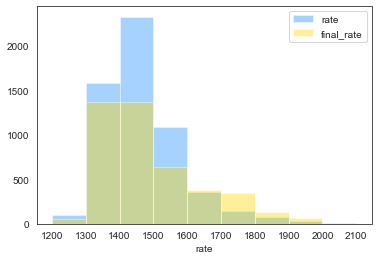

In [81]:
# 遷移後レートと最終レートを比較する

# スタージェスの公式でヒストグラムの階級数の目安を確認
sturges_rule(len(kagaribi_rate_dict))
bins=list(range(1200,2200,100))
len(bins)

sns.distplot(list(kagaribi_rate_dict.values()), kde=False, bins=bins, color='dodgerblue', label="rate")
sns.distplot(df_rate[df_rate != "-"].rate, kde=False, bins=bins, color='gold', label="final_rate")
plt.legend()
plt.xticks(bins)
plt.savefig('final_rate_hist.png')
plt.show()